# Solving Classification Using XGBoost

This notebook demos how to use XGBoost to solve a classification problem. We use the dataset Titanic for this, which can be found at: https://www.kaggle.com/competitions/titanic/data
<br>Once the data has been downloaded, unzip the file and place the `titanic` folder in the directory of your notebook.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

After importing all our required libraries, we load the `train.csv` and `test.csv` files into dataframes. 

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/utsavns96/CS418_Presentation/main/titanic/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/utsavns96/CS418_Presentation/main/titanic/test.csv')

We will start with exploring our dataset to understand how the data is provided.

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


The columns `PassengerId`, `Name`, `Ticket` and `Cabin` are not of any use to solve the classification problem, so we drop them from our dataframes.

In [ ]:
train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)
test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

After dropping these columns, we are left with this:

In [ ]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


We can now take a look at cleaning our data, and to do so, we need to explore it first.

In [ ]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We investigate what columns have null values using .isna().sum() to give us a total count of all null values.

In [ ]:
train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

We can also plot a correlation matrix of our columns: 

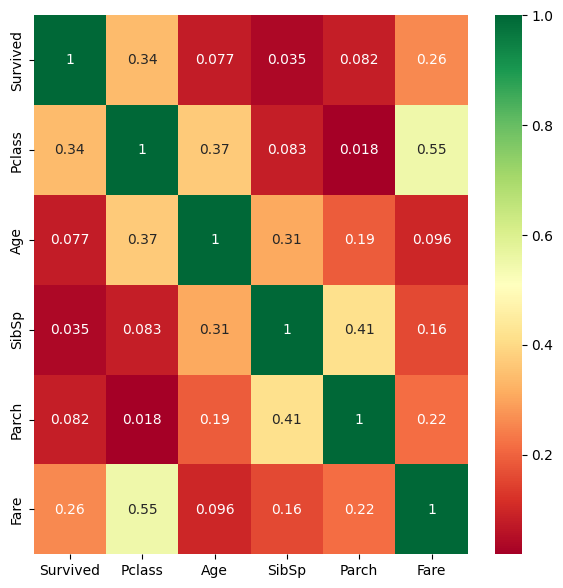

In [ ]:
#Plotting correlation heatmap
corr = train.corr()
corr = corr.apply(abs)
plt.figure(figsize=(7,7))
map = sns.heatmap(corr,annot=True,cmap="RdYlGn")

We can now start handling the null/0/nan values and replace them with the mean of the respective columns.

In [ ]:
#Replacing null values by column mean
train['Age'].fillna(train['Age'].mean(),inplace=True)
test['Age'].fillna(test['Age'].mean(),inplace=True)

In [ ]:
#Replacing 0’s & nulls by column mean
train['Fare'] = train['Fare'].replace(0, train['Fare'].mean())
train['Fare'].replace('nan',np.nan,inplace=True)
train['Fare'].fillna(train['Fare'].mean(),inplace=True)
test['Fare'] = test['Fare'].replace(0, test['Fare'].mean())
test['Fare'].replace('nan',np.nan,inplace=True)
test['Fare'].fillna(test['Fare'].mean(),inplace=True)

In [ ]:
#Replacing nulls by column mean 
train['Embarked'].replace('nan',np.nan,inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)
test['Embarked'].replace('nan',np.nan,inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0],inplace=True)

Now, we check how many distinct values are present in the column `Sex`.

In [ ]:
#Printing unique values in 'Sex' column
train['Sex'].unique()

array(['male', 'female'], dtype=object)

To use this column, we will need to turn in into a numeric field. Therefore, we map the value `male` to `0`, and `female` to `1`.

In [ ]:
#Mappping categorical to numeric
train['Sex']=train['Sex'].map({'male':0,'female':1})
test['Sex']=test['Sex'].map({'male':0,'female':1})

Similarly, for the column Embarked, we check the unique values:

In [ ]:
#Printing unique values in 'Embarked' column
train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

We map `S` to 0, `C` to `1`, and `Q` to `2`.

In [ ]:
#Mappping categorical to numeric
train['Embarked']=train['Embarked'].map({'S':0,'C':1,'Q':2})
test['Embarked']=test['Embarked'].map({'S':0,'C':1,'Q':2})

The column `Survived` is our target column, so we drop it from the `train` dataframe and assign it to `y`.

In [ ]:
#Dropping the 'Survived' column
x=train.drop(['Survived'],axis=1)
y=train['Survived']

Now, the `train` dataframe is split into two parts. The first part will be used to train the model in XGBoost, and the second part will be used to evaluate the performance of the model.

In [ ]:
#Splitting the data into train & test
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

We will use the XGBoost for the classification. We split the data into train and test datasets using `train_test_split` above, and then fit it using our `XGBClassifier`

In [ ]:
#Specifying our classifier
xgb = XGBClassifier(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

We calculate the model's score using `x_test` and `y_test` to check it's accuracy:

In [ ]:
#Calculating the model's score

xgb.score(X_test,y_test)

0.8251121076233184

We are now ready to make our prediction. To do so, we use the `.predict()` function and pass it the `X_test` split.

In [ ]:
y_pred = xgb.predict(X_test)
print(y_pred)

[0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0
 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1
 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1
 1]


Printing the confusion matrix, where the top left is true positive, and bottom left us our true negative

In [ ]:
confusion_matrix(y_test, y_pred)

array([[119,  20],
       [ 19,  65]])

Finally, we can find the actual prediction for our `test` dataframe,

In [ ]:
xgb.predict(test)

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,

And thus, we have generated a prediction of which passengers aboard the Titanic would survive, and which would not. The array of 0's and 1's we see above is the result, where 0 indicates that the passenger did not survive, and 1 indicates that the passenger survived.